In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from collections import Counter
import ast

In [2]:
main_df = pd.read_csv("../data/animes_better.csv")
columns_to_drop = ['title', 'aired', 'episodes', 'members', 'ranked', 'score', 'link', 'img_url']
main_df = main_df.drop(columns=columns_to_drop)
main_df

,uid,synopsis,genre,popularity,Type,Producers,Studios,Source,Themes,Demographic,Duration,Favorites,Streaming Platforms
0,28891,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",141,TV,"['Dentsu', 'Mainichi Broadcasting System', 'Mo...",['Production I.G'],Manga,"['School', 'Team Sports']",Shounen,24.0,15764,['Crunchyroll']
1,23273,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",28,TV,"['Aniplex', 'Dentsu', 'Kodansha', 'Fuji TV', '...",['A-1 Pictures'],Manga,"['Love Polygon', 'Music', 'School']",Shounen,22.0,86357,"['Crunchyroll', 'Netflix']"
2,34599,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",98,TV,"['AT-X', 'Takeshobo', 'Sony Music Communicatio...",['Kinema Citrus'],Web manga,['Theme Unknown'],Demographic Unknown,25.0,44597,"['Crunchyroll', 'HIDIVE', 'Netflix']"
3,5114,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",4,TV,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...",['Bones'],Manga,['Theme Unknown'],Shounen,24.0,227331,['Crunchyroll']
4,31758,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",502,Movie,"['Aniplex', 'Kodansha']",['Shaft'],Light novel,['Theme Unknown'],Demographic Unknown,83.0,7588,['No Streaming Platform']
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,10075,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...",2382,OVA,['Producer Unknown'],['Pierrot'],Manga,['Theme Unknown'],Shounen,6.0,85,['No Streaming Platform']
16212,35828,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']",1648,TV,"['TBS', 'Grooove', 'Nichion', 'Exit Tunes', 'O...",['8bit'],Web manga,"['Mythology', 'Pets', 'School']",Demographic Unknown,24.0,753,['Crunchyroll']
16213,10378,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']",1547,TV,"['TV Tokyo', 'Lantis', 'Pony Canyon', 'TV Toky...",['Diomedéa'],Manga,['Anthropomorphic'],Shounen,24.0,178,"['Crunchyroll', 'HIDIVE']"
16214,33082,"For years, the Niflheim Empire and the kingdom...",['Action'],2154,Movie,['Square Enix'],['Square Enix Visual Works'],Game,['Theme Unknown'],Demographic Unknown,115.0,154,['No Streaming Platform']


In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16216 entries, 0 to 16215
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   uid                  16216 non-null  int64  
 1   synopsis             15453 non-null  object 
 2   genre                16216 non-null  object 
 3   popularity           16216 non-null  int64  
 4   Type                 16054 non-null  object 
 5   Producers            16216 non-null  object 
 6   Studios              16216 non-null  object 
 7   Source               16054 non-null  object 
 8   Themes               16216 non-null  object 
 9   Demographic          16054 non-null  object 
 10  Duration             16054 non-null  float64
 11  Favorites            16216 non-null  int64  
 12  Streaming Platforms  16216 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 1.6+ MB


In [4]:
main_df['synopsis'] = main_df['synopsis'].fillna('')

stop_words = set(stopwords.words('english'))
stop_words.update(['anime', 'source'])
main_df['synopsis_clean'] = main_df['synopsis'].str.replace('[Written by MAL Rewrite]', '', regex=False)

def preprocess(text):
    tokens = [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

main_df['synopsis_clean'] = main_df['synopsis_clean'].apply(preprocess)

def extract_keywords(text):
    if not text.strip(): 
        return []
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    try:
        tfidf_matrix = vectorizer.fit_transform([text])
        feature_names = vectorizer.get_feature_names_out()
        tfidf_scores = zip(feature_names, tfidf_matrix.toarray()[0])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords = [word for word, score in sorted_tfidf_scores[:5]]
        return top_keywords
    except ValueError:
        return []

main_df['keywords'] = main_df['synopsis_clean'].apply(extract_keywords)

main_df = main_df.drop(columns=['synopsis', 'synopsis_clean'])

In [5]:
def encode_multilabel_predictor(df, predictor):
    df[predictor] = df[predictor].apply(lambda x: x.strip("[]").replace("'", "").split(', '))
    
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[predictor])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return encoded_df, mlb.classes_

In [6]:
encoded_genre_df, genre_classes = encode_multilabel_predictor(main_df, 'genre')

encoded_df = pd.concat([encoded_genre_df, main_df.drop(columns=['genre'])], axis=1)

X = encoded_df[genre_classes]
y = encoded_df['popularity']

valid_indices = X.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Genre - MSE: {mse:.2f}, R²: {r2:.2f}")

Genre - MSE: 11994712.77, R²: 0.46


In [7]:
X.columns

Index(['', 'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical',
       'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military',
       'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

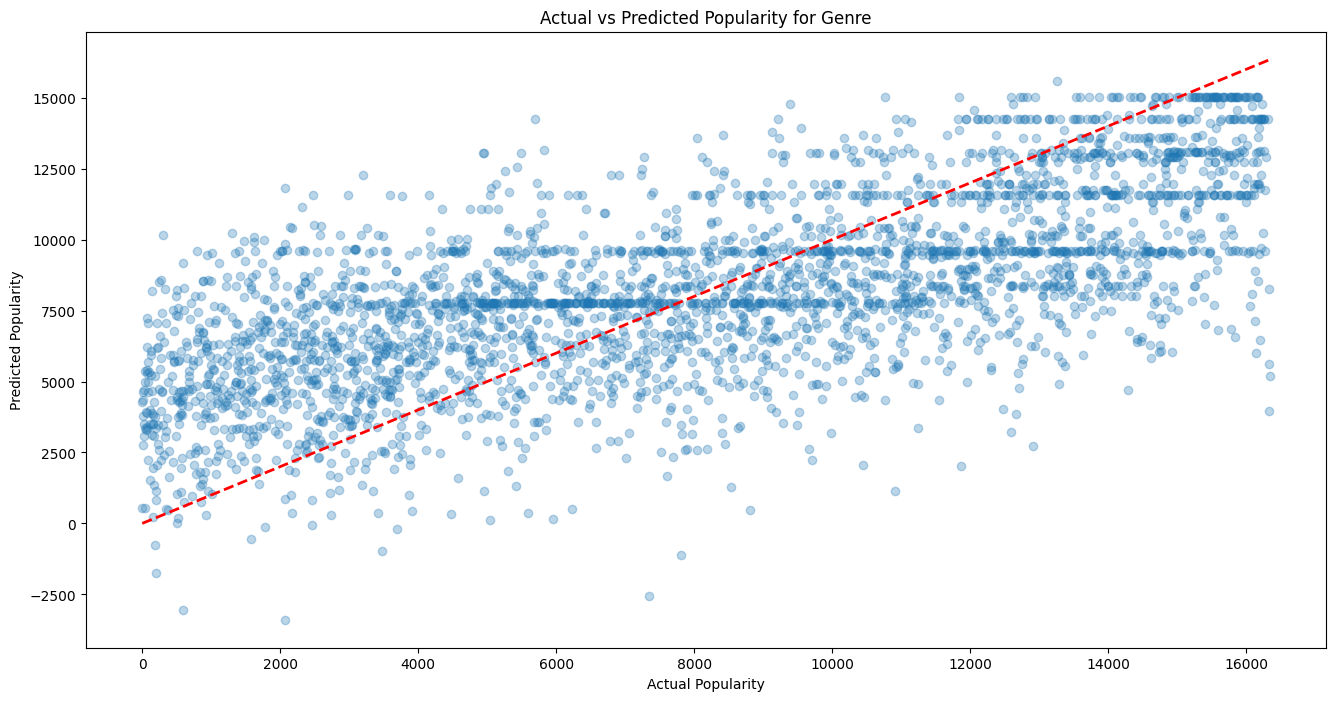

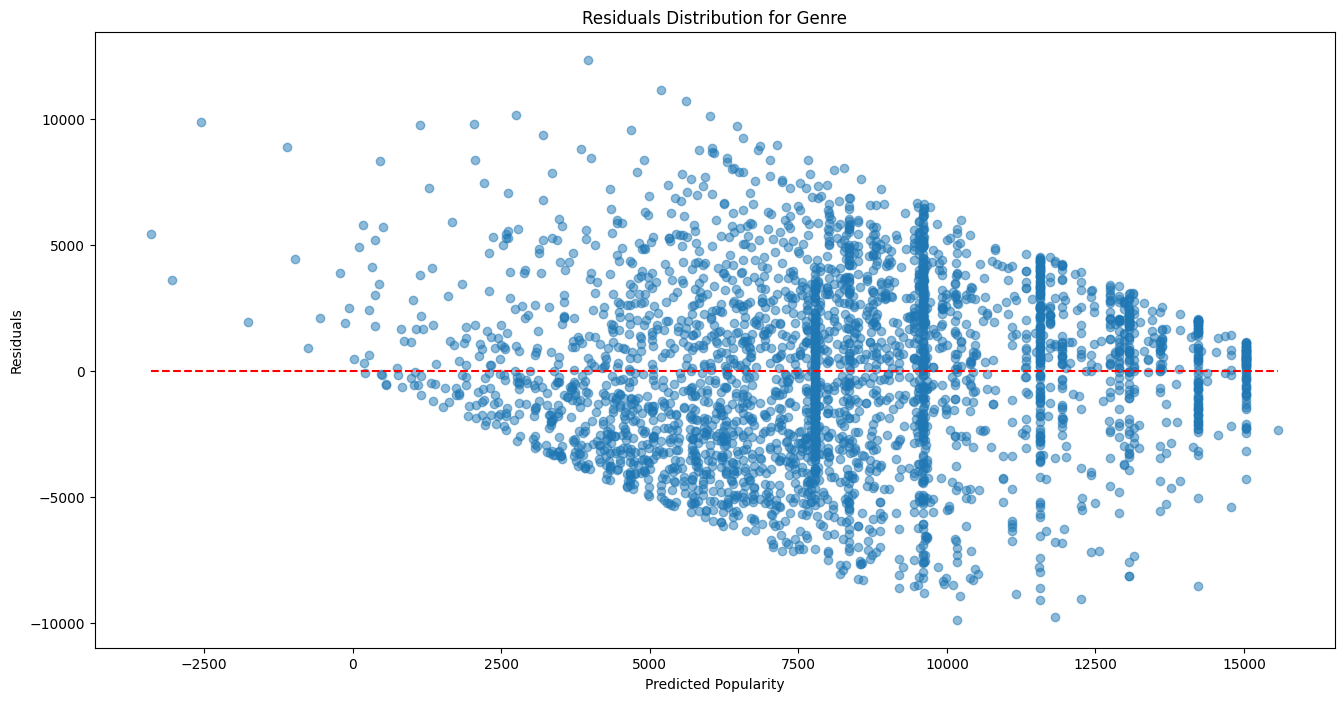

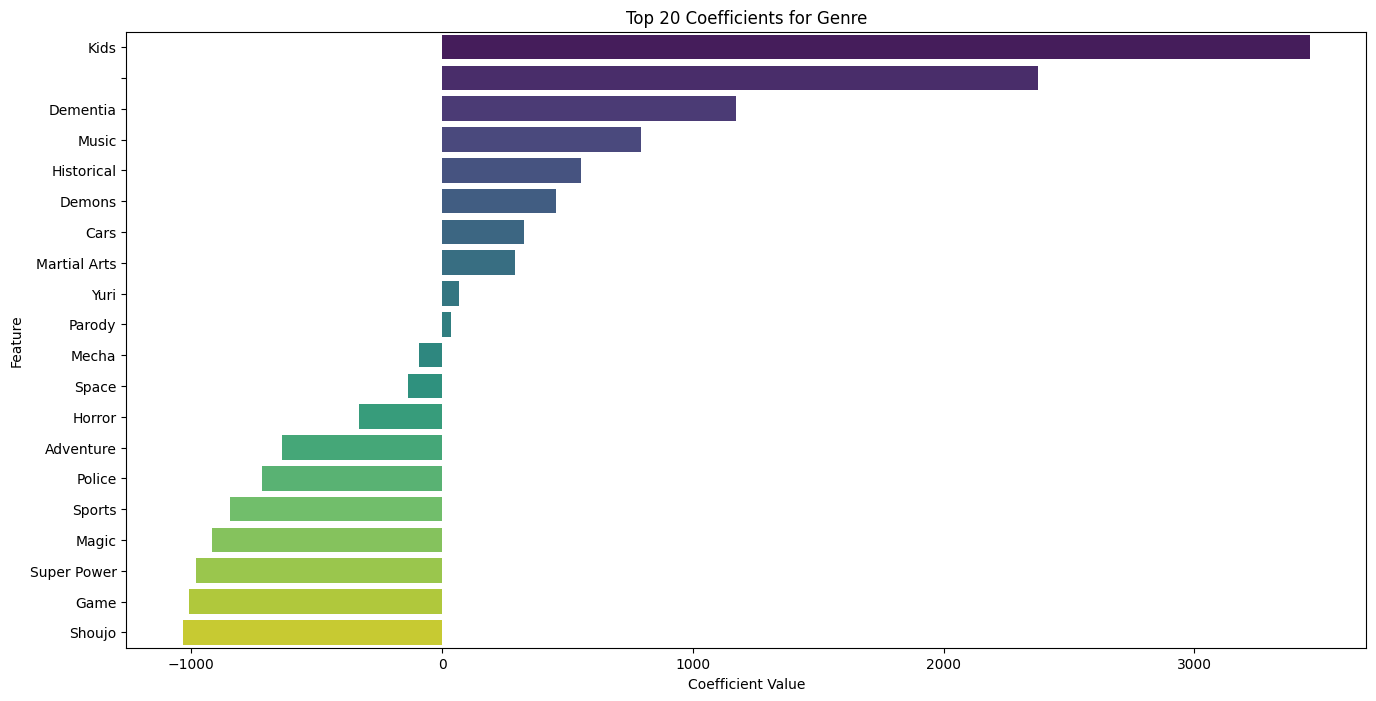

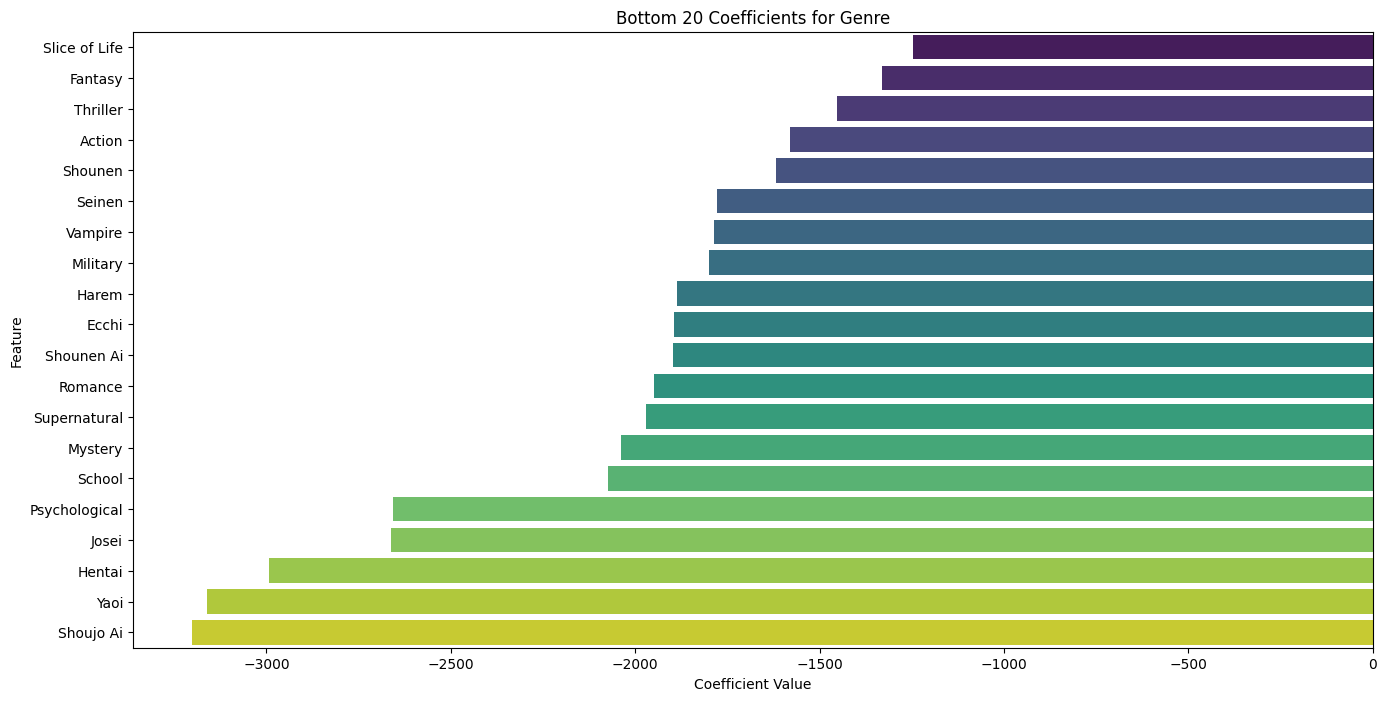

In [8]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Actual vs Predicted Popularity for Genre')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title(f'Residuals Distribution for Genre')
plt.show()

# Coefficient plot
coeffs = model.coef_
coeff_names = genre_classes
coeff_df = pd.DataFrame({'Feature': coeff_names, 'Coefficient': coeffs})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].head(20), y=coeff_df['Feature'].head(20), hue=coeff_df['Feature'].head(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title(f'Top 20 Coefficients for Genre')
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].tail(20), y=coeff_df['Feature'].tail(20), hue=coeff_df['Feature'].tail(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title(f'Bottom 20 Coefficients for Genre')
plt.show()

In [9]:
producer_df = main_df[(main_df['Producers'] != "['Producer Unknown']") & (main_df['Producers'] != "['']")].copy()

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

producer_df.loc[:, 'Producers'] = producer_df['Producers'].apply(safe_literal_eval)

all_producers = [producer for sublist in producer_df['Producers'] for producer in sublist]
producer_counts = Counter(all_producers)

producer_df.loc[:, 'Producer_Count'] = producer_df['Producers'].apply(lambda x: sum([producer_counts[producer] for producer in x]))

X = producer_df[['Producer_Count']]
y = producer_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression with Producer Count - MSE: {mse_linear:.2f}, R²: {r2_linear:.2f}")

Linear Regression with Producer Count - MSE: 18073041.18, R²: 0.15


In [10]:
X.columns

Index(['Producer_Count'], dtype='object')

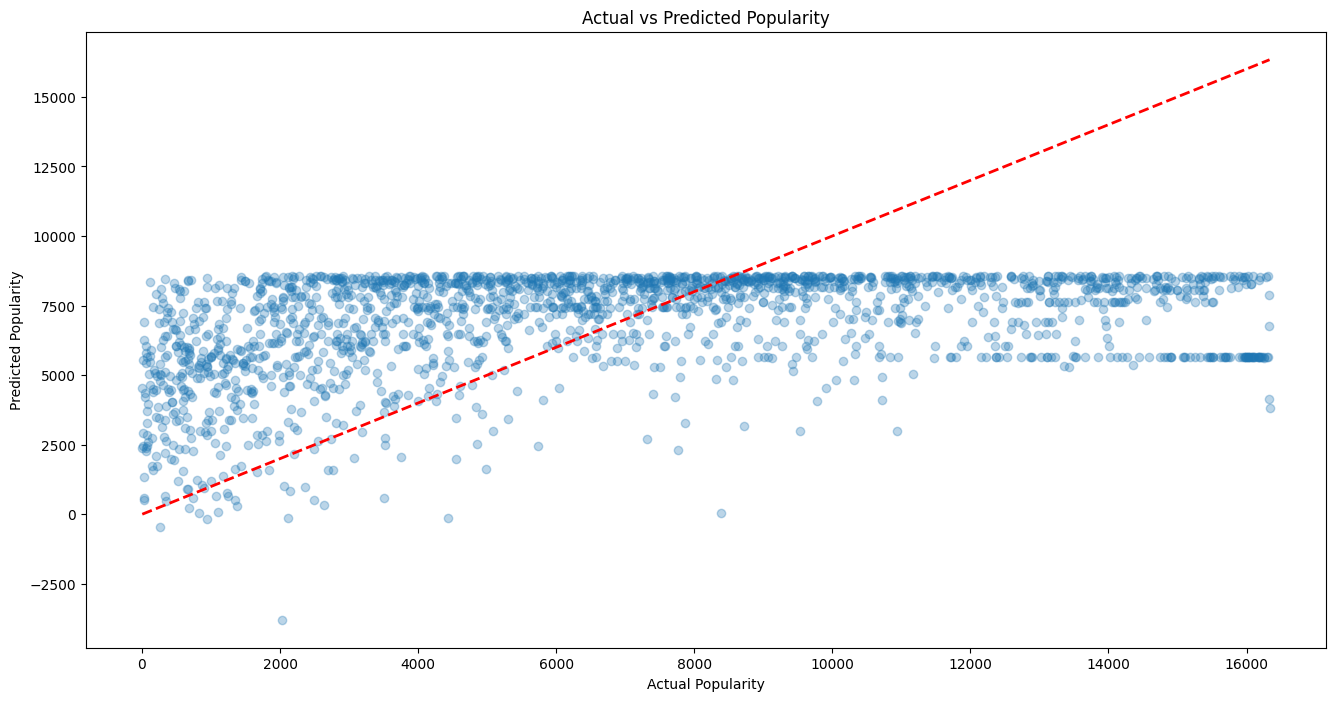

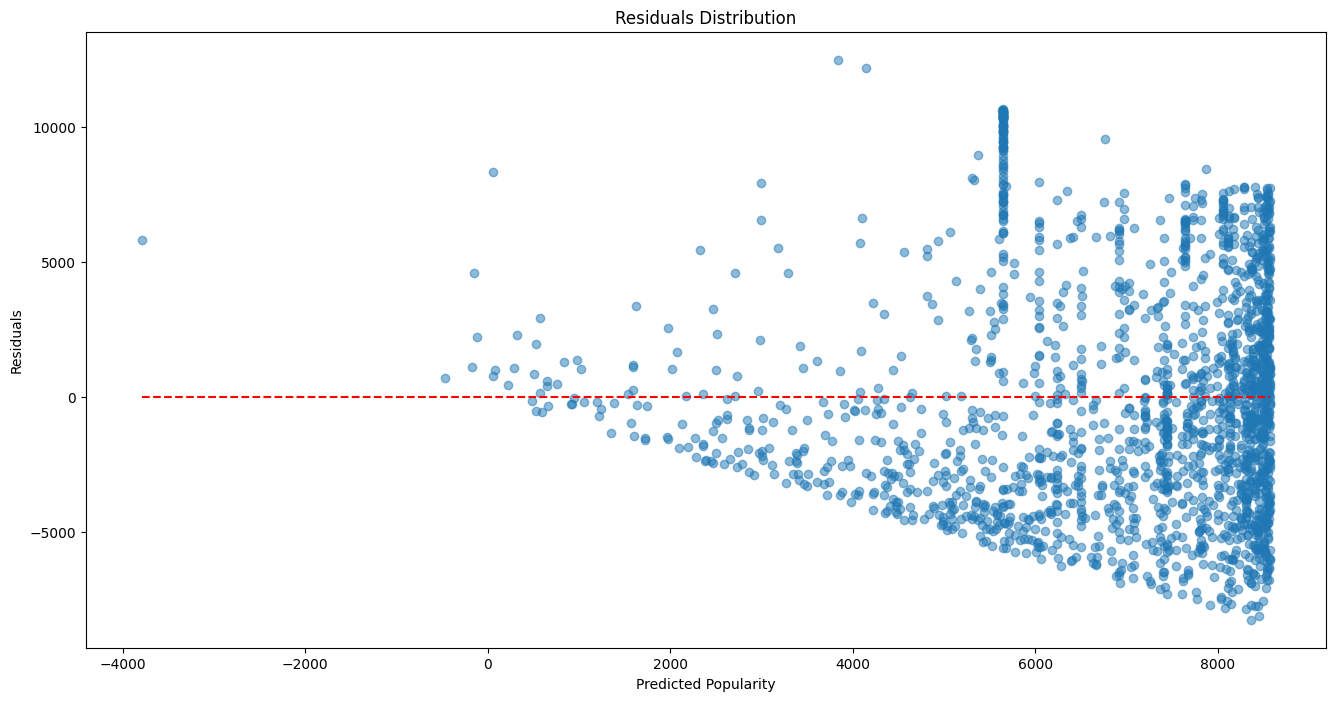

In [11]:
formatter = FuncFormatter(lambda x, pos: f'{x:.0f}')

plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred_linear, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity')
plt.show()

residuals = y_test - y_pred_linear
plt.figure(figsize=(16, 8))
plt.scatter(y_pred_linear, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_linear.min(), xmax=y_pred_linear.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


In [12]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

def encode_multilabel_predictor(df, predictor):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[predictor])
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    return encoded_df, mlb.classes_

In [13]:
studio_df = main_df.copy()
studio_df['Studios'] = studio_df['Studios'].apply(safe_literal_eval)
studio_df = studio_df[~(studio_df['Studios'].isin([['Studio Unknown'], []]))]

studios_encoded_df, studio_classes = encode_multilabel_predictor(studio_df, 'Studios')

studio_df_with_dummies = pd.concat([studio_df, studios_encoded_df], axis=1)

studio_df_with_dummies.drop(['Studios'], axis=1, inplace=True)

X = studio_df_with_dummies[studio_classes]
y = studio_df_with_dummies['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Studios - MSE: {mse:.2f}, R²: {r2:.2f}")

Studios - MSE: 271914975667867805380786067079168.00, R²: -16446595957587506660114432.00


In [14]:
all_studios = [studio for sublist in studio_df['Studios'] for studio in sublist]
studio_counts = Counter(all_studios)

studio_df.loc[:, 'Studio_Count'] = studio_df['Studios'].apply(lambda x: sum([studio_counts[studio] for studio in x]))

X = studio_df[['Studio_Count']]
y = studio_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression with Studio Count - MSE: {mse_linear:.2f}, R²: {r2_linear:.2f}")


Linear Regression with Studio Count - MSE: 16537668.64, R²: -0.00


In [15]:
studio_df = main_df[(main_df['Studios'] != "['Studio Unknown']") & (main_df['Studios'] != "['']")].copy()

studio_df.loc[:, 'Studios'] = studio_df['Studios'].apply(safe_literal_eval)

studios_encoded_df, studio_classes = encode_multilabel_predictor(studio_df, 'Studios')

studio_df_with_dummies = pd.concat([studio_df, studios_encoded_df], axis=1)

studio_df_with_dummies.drop(['Studios'], axis=1, inplace=True)

X = studio_df_with_dummies[studio_classes]
y = studio_df_with_dummies['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Studios - MSE: {mse:.2f}, R²: {r2:.2f}")


Studios - MSE: 171223109749591135364861436887040.00, R²: -10432049593098003873267712.00


In [16]:
theme_df = main_df[(main_df['Themes'] != "['Theme Unknown']") & (main_df['Themes'] != "['']")].copy()

theme_df.loc[:, 'Themes'] = theme_df['Themes'].apply(safe_literal_eval)

all_themes = [theme for sublist in theme_df['Themes'] for theme in sublist]
theme_counts = Counter(all_themes)

theme_df.loc[:, 'Theme_Count'] = theme_df['Themes'].apply(lambda x: sum([theme_counts[theme] for theme in x]))

X = theme_df[['Theme_Count']]
y = theme_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression with Theme Count - MSE: {mse_linear:.2f}, R²: {r2_linear:.2f}")

Linear Regression with Theme Count - MSE: 18480112.10, R²: 0.04


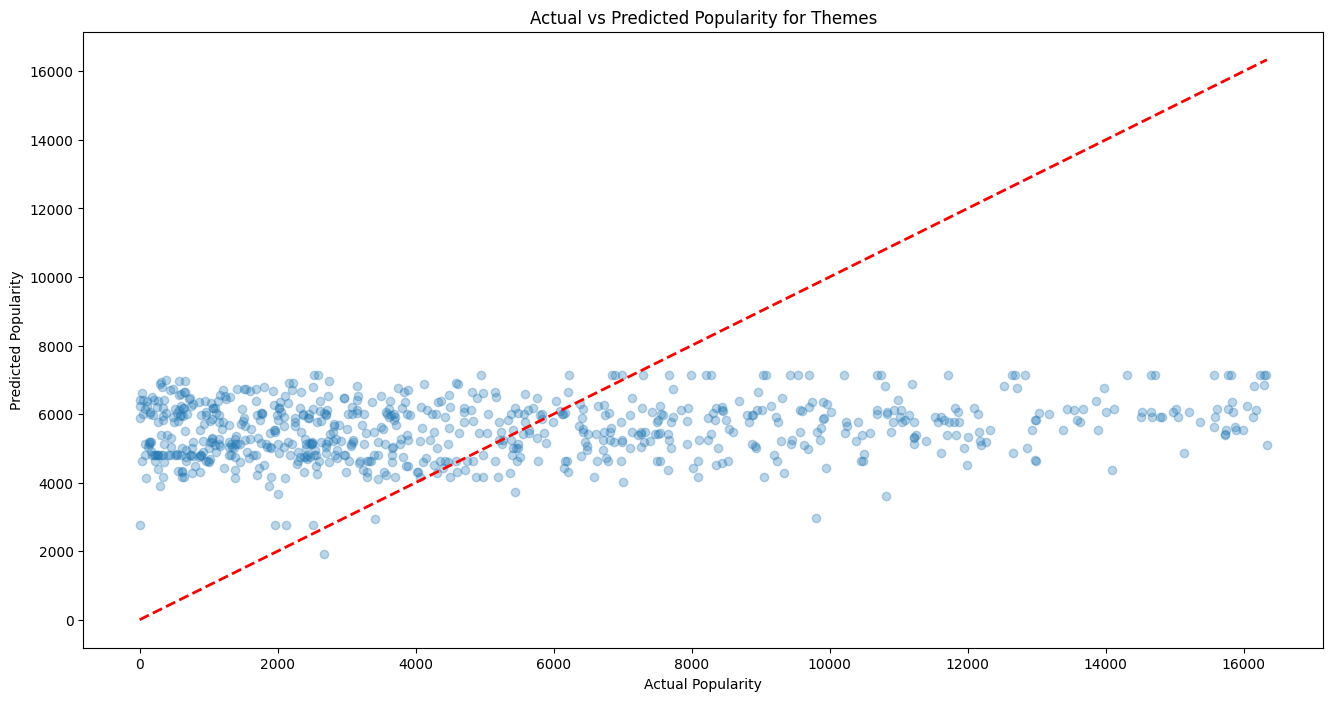

In [17]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred_linear, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity for Themes')
plt.show()

In [18]:
platform_df = main_df[(main_df['Streaming Platforms'] != "['Platform Unknown']") & (main_df['Streaming Platforms'] != "['']")].copy()

platform_df.loc[:, 'Streaming Platforms'] = platform_df['Streaming Platforms'].apply(safe_literal_eval)

platforms_encoded_df, platform_classes = encode_multilabel_predictor(platform_df, 'Streaming Platforms')

platform_df_with_dummies = pd.concat([platform_df, platforms_encoded_df], axis=1)

platform_df_with_dummies.drop(['Streaming Platforms'], axis=1, inplace=True)

X = platform_df_with_dummies[platform_classes]
y = platform_df_with_dummies['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Streaming Platforms - MSE: {mse:.2f}, R²: {r2:.2f}")

Streaming Platforms - MSE: 5955856433440314443694080.00, R²: -265961163986397472.00


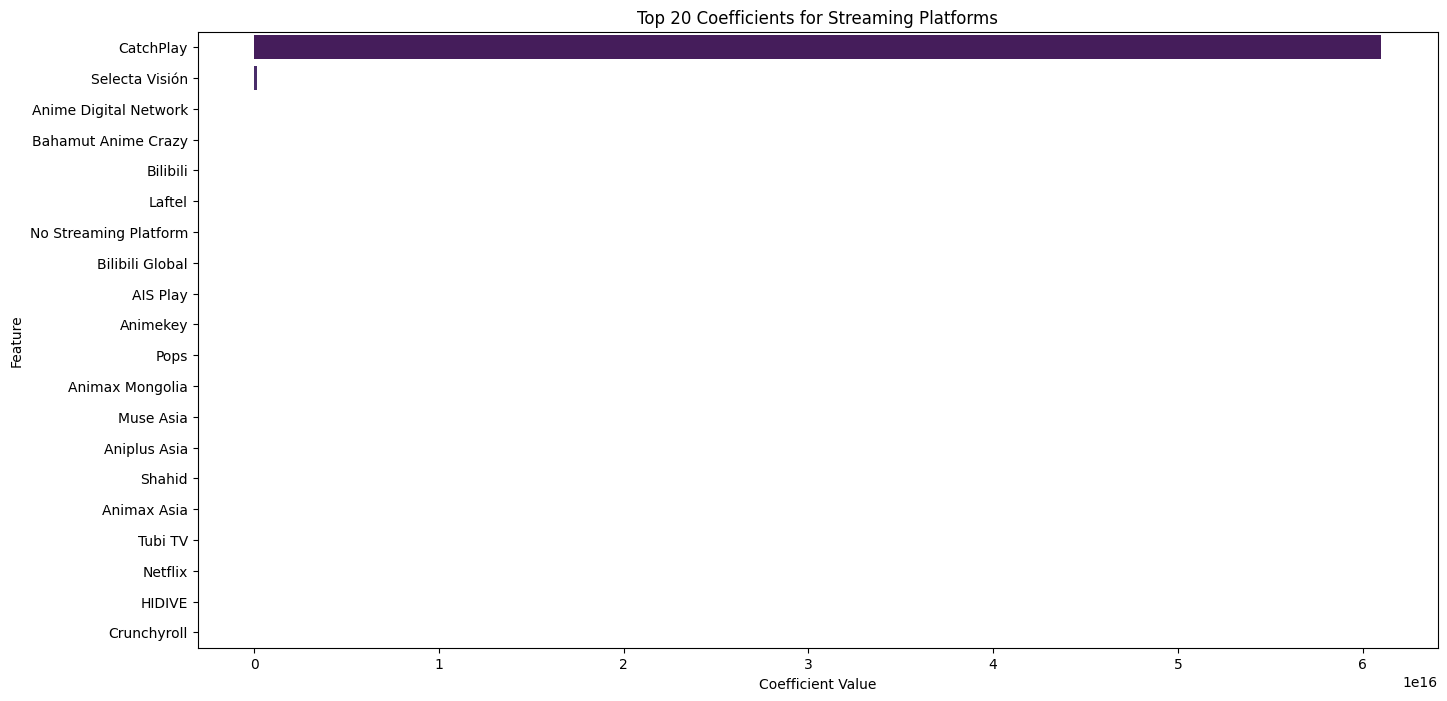

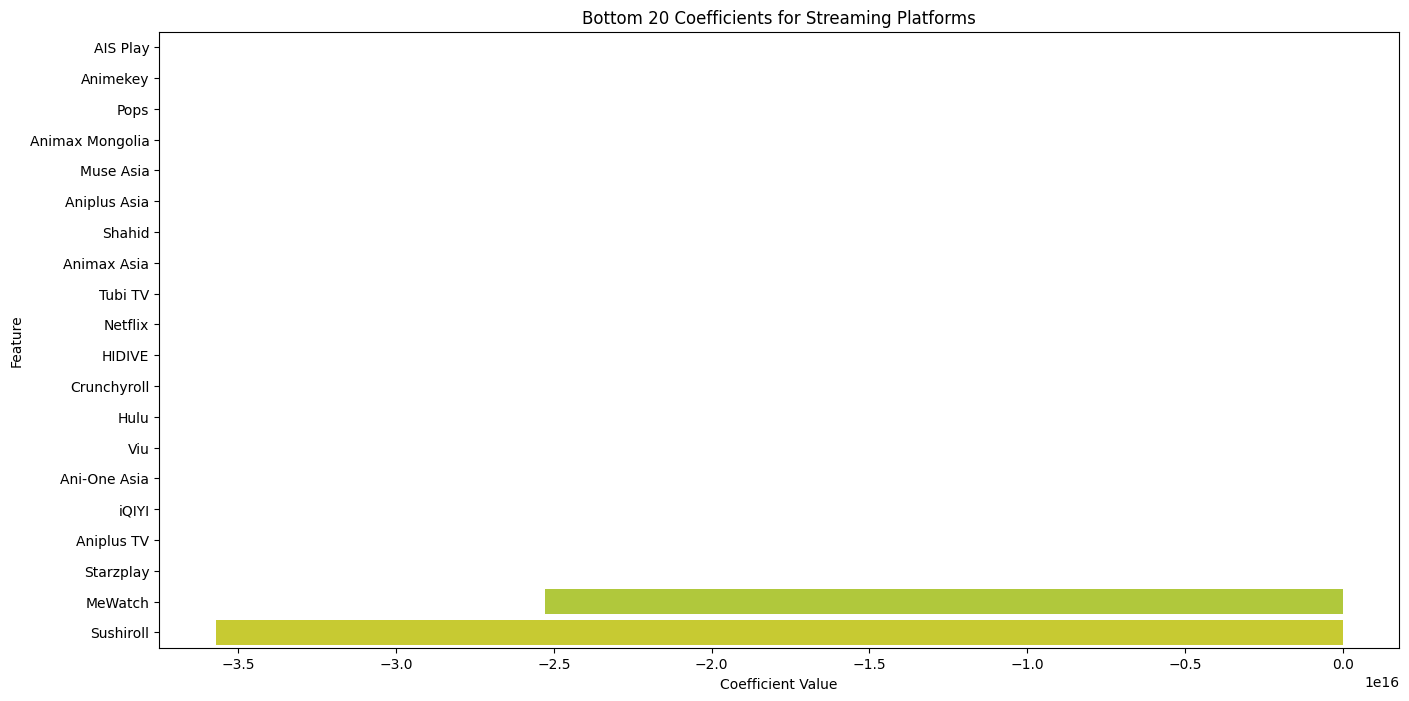

In [19]:
coeffs = model.coef_
coeff_names = platform_classes
coeff_df = pd.DataFrame({'Feature': coeff_names, 'Coefficient': coeffs})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].head(20), y=coeff_df['Feature'].head(20), hue=coeff_df['Feature'].head(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title('Top 20 Coefficients for Streaming Platforms')
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x=coeff_df['Coefficient'].tail(20), y=coeff_df['Feature'].tail(20), hue=coeff_df['Feature'].tail(20), palette="viridis")
plt.xlabel('Coefficient Value')
plt.title('Bottom 20 Coefficients for Streaming Platforms')
plt.show()

In [20]:
all_platforms = [platform for sublist in platform_df['Streaming Platforms'] for platform in sublist]
platform_counts = Counter(all_platforms)

platform_df.loc[:, 'Platform_Count'] = platform_df['Streaming Platforms'].apply(lambda x: sum([platform_counts[platform] for platform in x]))

X = platform_df[['Platform_Count']]
y = platform_df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression with Platform Count - MSE: {mse_linear:.2f}, R²: {r2_linear:.2f}")

Linear Regression with Platform Count - MSE: 17371010.13, R²: 0.22


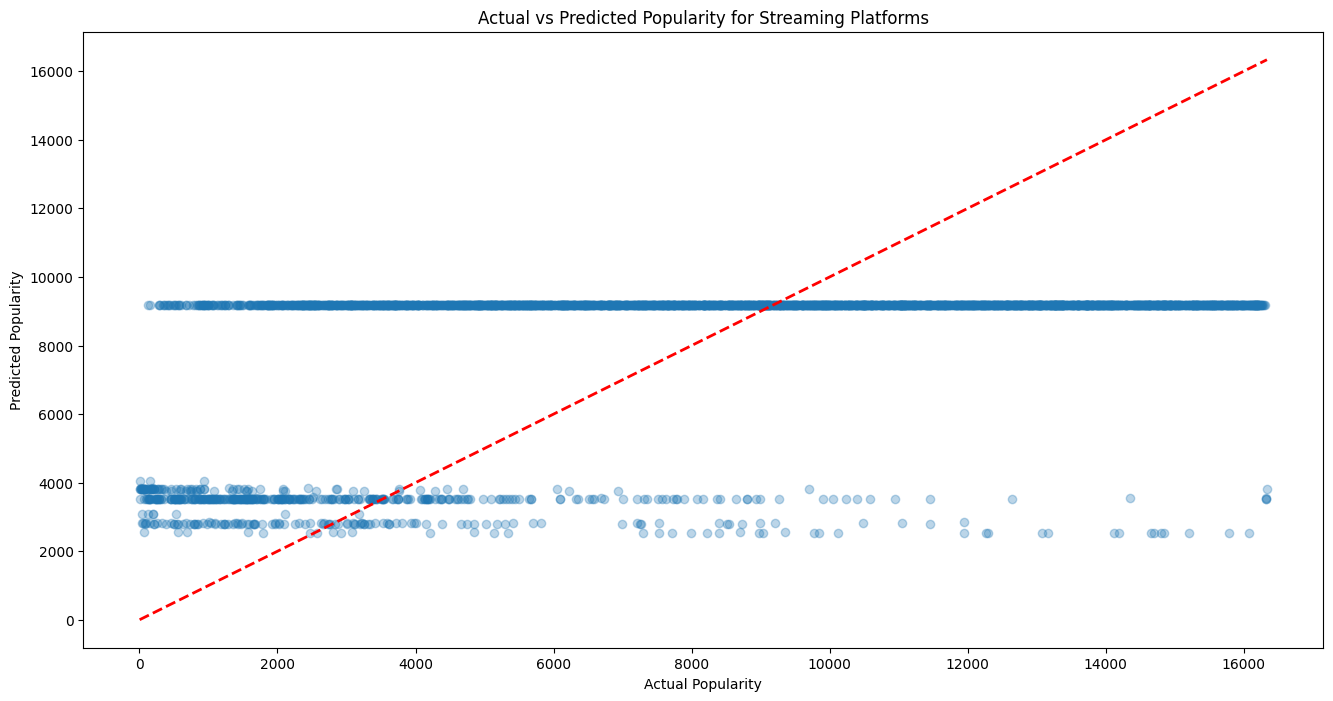

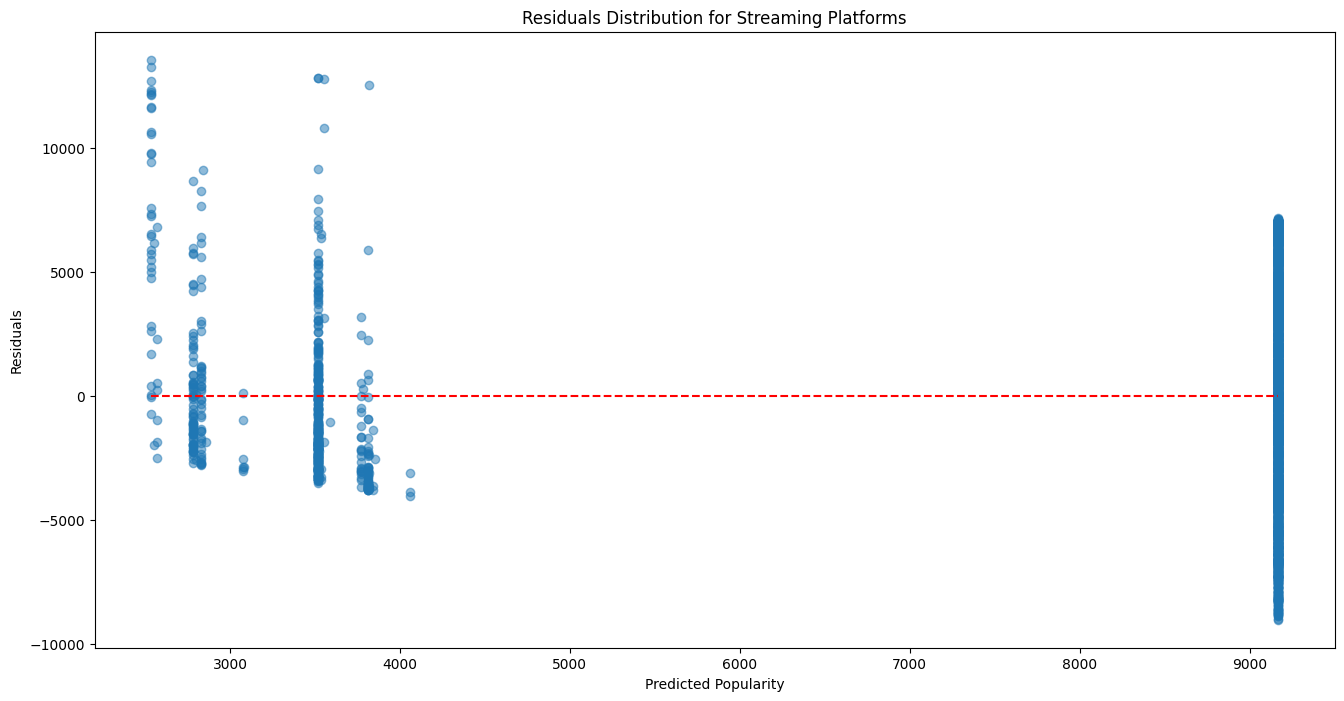

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred_linear, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity for Streaming Platforms')
plt.show()

residuals = y_test - y_pred_linear
plt.figure(figsize=(16, 8))
plt.scatter(y_pred_linear, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_linear.min(), xmax=y_pred_linear.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals Distribution for Streaming Platforms')
plt.show()



In [38]:
keyword_df = main_df.copy()

keyword_df.loc[:, 'keywords'] = keyword_df['keywords']

keywords_encoded_df, keyword_classes = encode_multilabel_predictor(keyword_df, 'keywords')

keyword_df_with_dummies = pd.concat([keyword_df, keywords_encoded_df], axis=1)

keyword_df_with_dummies.drop(['keywords'], axis=1, inplace=True)

X = keyword_df_with_dummies[keyword_classes].drop(columns=['popularity'])
y = keyword_df_with_dummies['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Keywords - MSE: {mse:.2f}, R²: {r2:.2f}")

Keywords - MSE: 627163811311344486620645480726528.00, R²: -28006252186817807635185664.00


Adjusted number of coefficients: 14781
Adjusted number of features: 14781


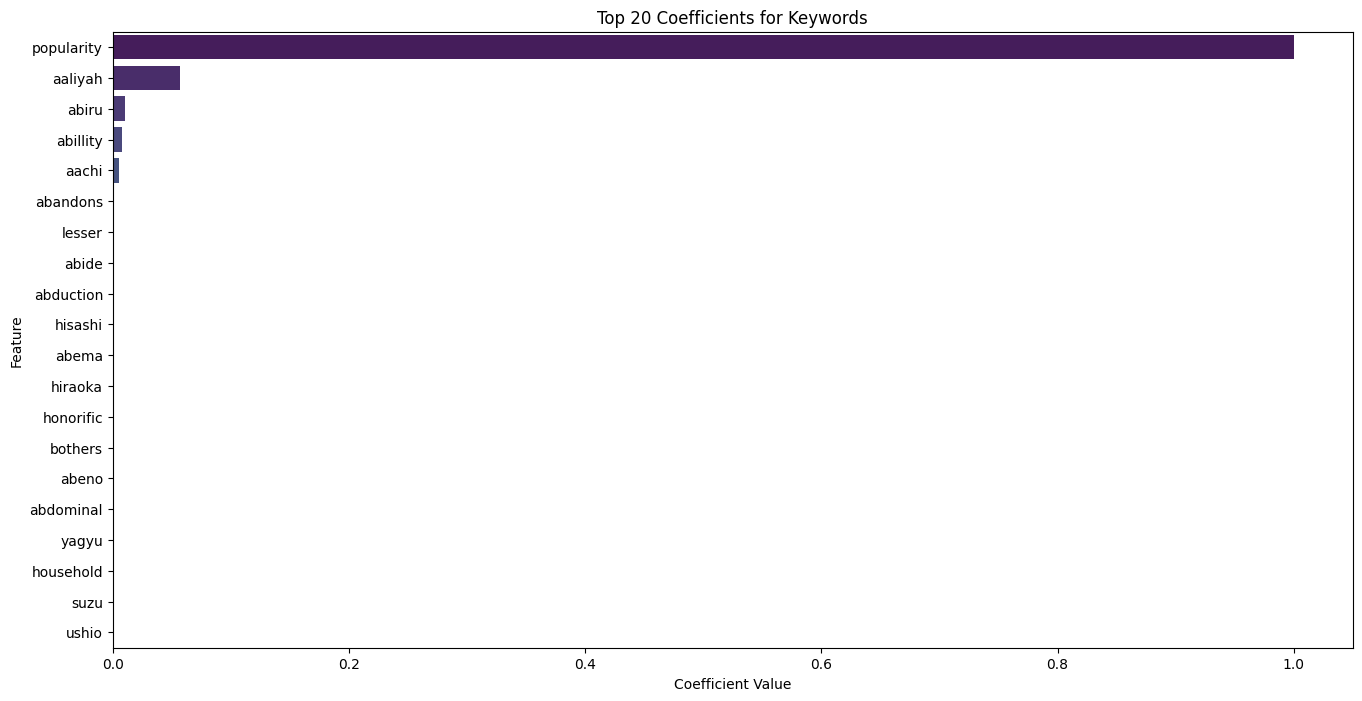

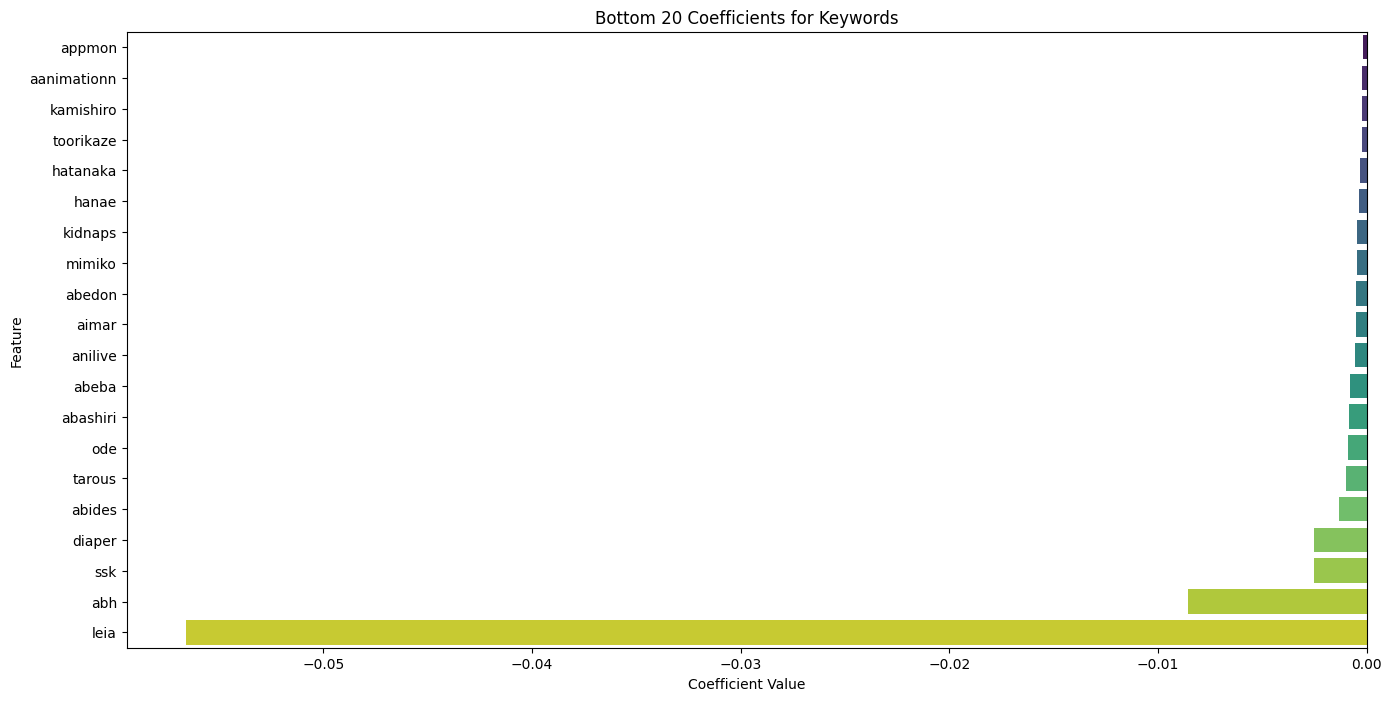

In [45]:
if len(coeffs) > len(coeff_names):
    coeffs = coeffs[:len(coeff_names)].drop(columns=['popularity'])
elif len(coeffs) < len(coeff_names):
    coeff_names = coeff_names[:len(coeffs)].drop(columns=['popularity'])

print(f"Adjusted number of coefficients: {len(coeffs)}")
print(f"Adjusted number of features: {len(coeff_names)}")

if len(coeffs) == len(coeff_names):
    coeff_df = pd.DataFrame({'Feature': coeff_names, 'Coefficient': coeffs})
    coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(16, 8))
    sns.barplot(x=coeff_df['Coefficient'].head(20), y=coeff_df['Feature'].head(20), hue=coeff_df['Feature'].head(20), palette="viridis")
    plt.xlabel('Coefficient Value')
    plt.title('Top 20 Coefficients for Keywords')
    plt.show()

    plt.figure(figsize=(16, 8))
    sns.barplot(x=coeff_df['Coefficient'].tail(20), y=coeff_df['Feature'].tail(20), hue=coeff_df['Feature'].tail(20), palette="viridis")
    plt.xlabel('Coefficient Value')
    plt.title('Bottom 20 Coefficients for Keywords')
    plt.show()
else:
    print("The lengths of coefficients and feature names do not match.")

In [46]:
from sklearn.preprocessing import StandardScaler

X = main_df[['Duration']].values
y = main_df['popularity'].values

valid_indices = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[valid_indices]
y = y[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Duration - MSE: {mse:.2f}, R²: {r2:.2f}")

Duration - MSE: 21369334.61, R²: 0.04


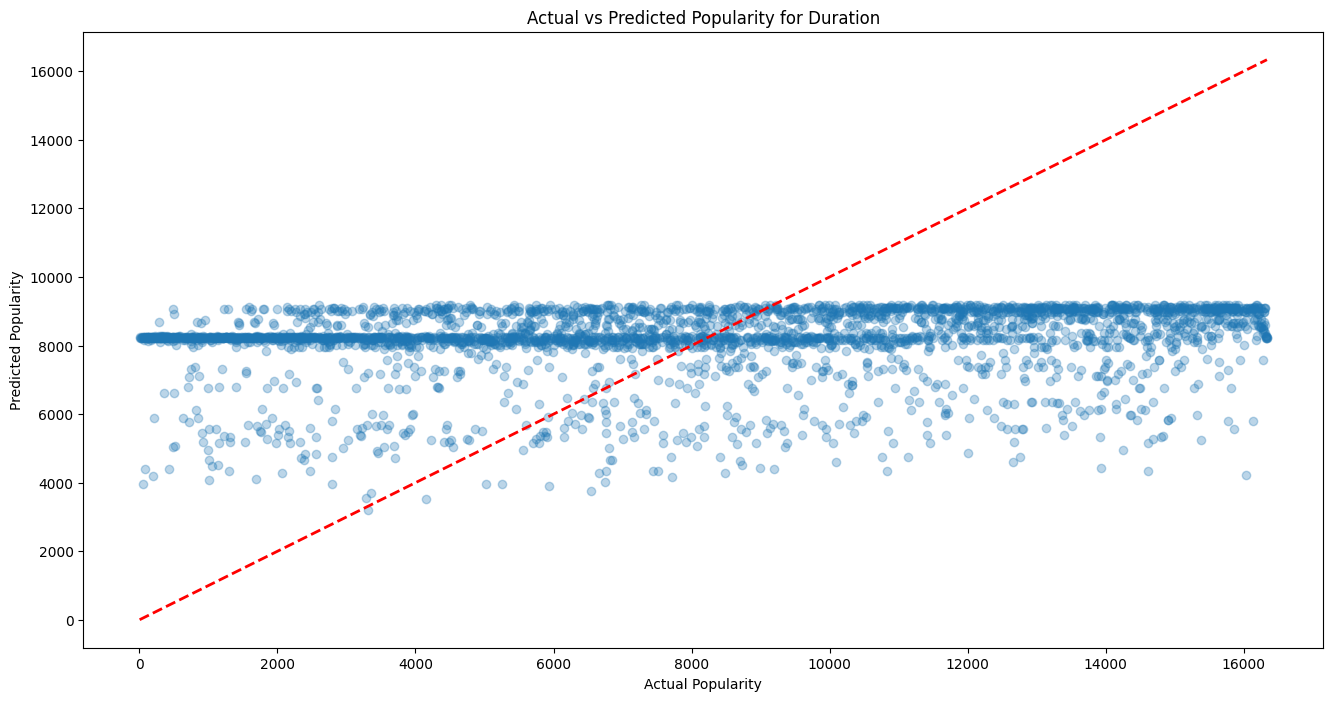

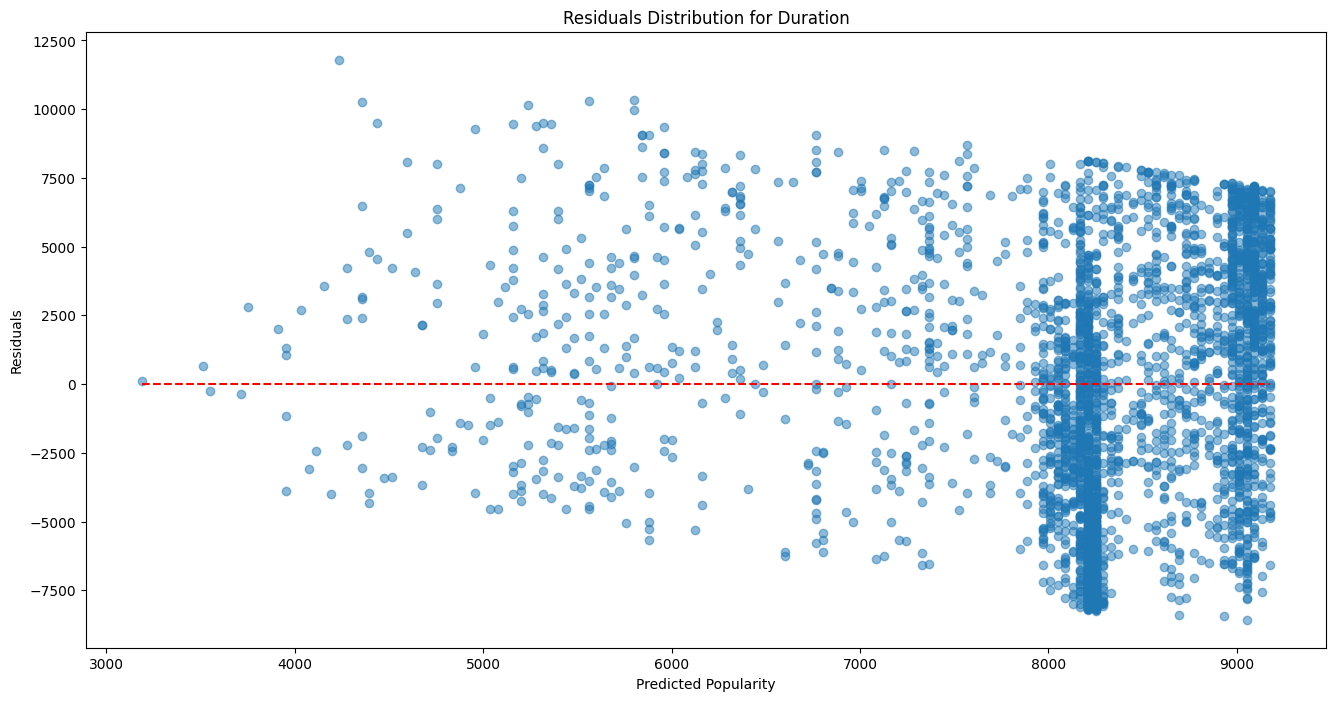

In [47]:
plt.figure(figsize=(16, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title(f'Actual vs Predicted Popularity for Duration')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(16, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title(f'Residuals Distribution for Duration')
plt.show()

Type - MSE: 18628757.31, R²: 0.16


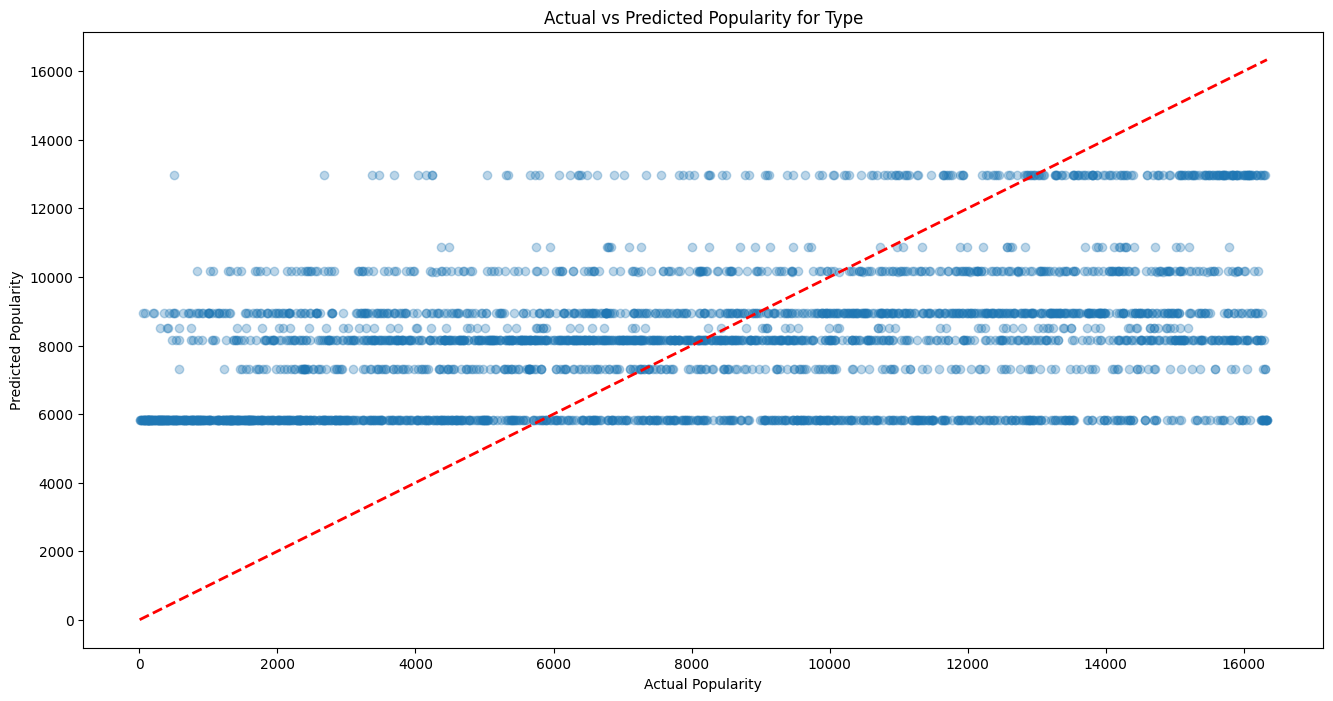

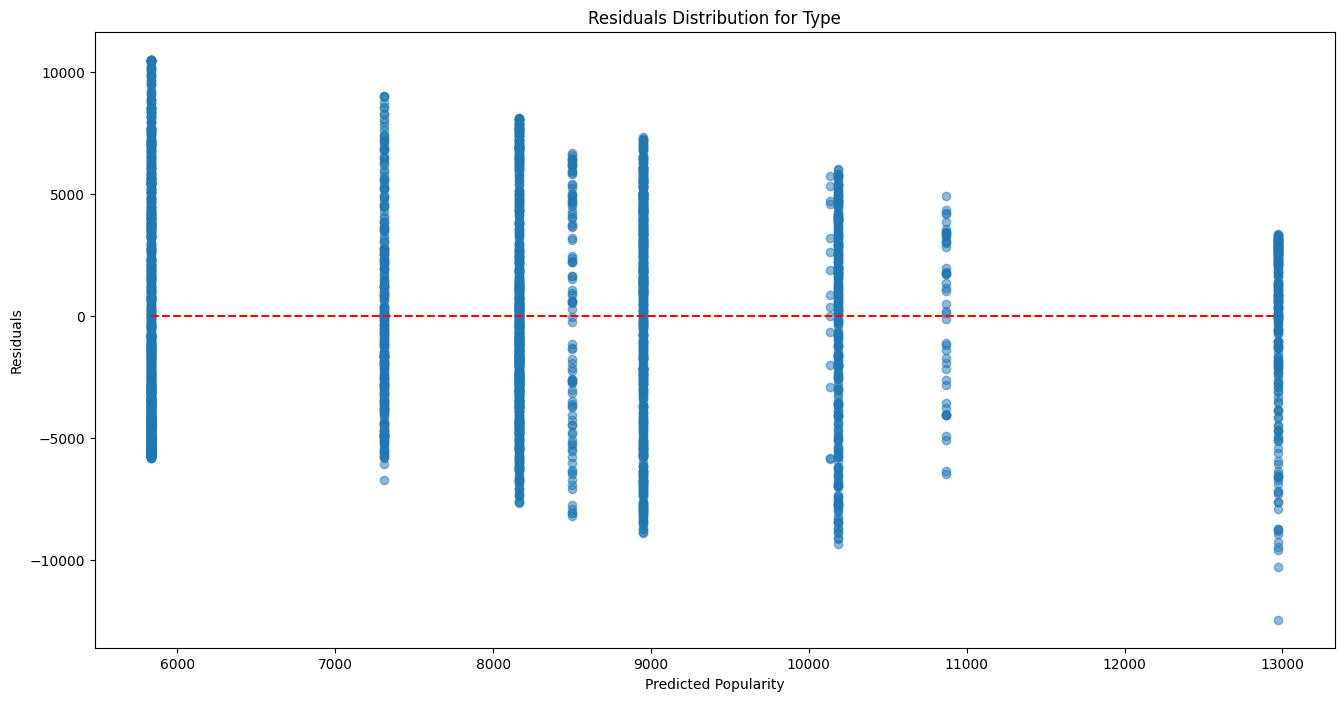

C:\Users\User\AppData\Local\Temp\ipykernel_28512\2727722633.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette="viridis")


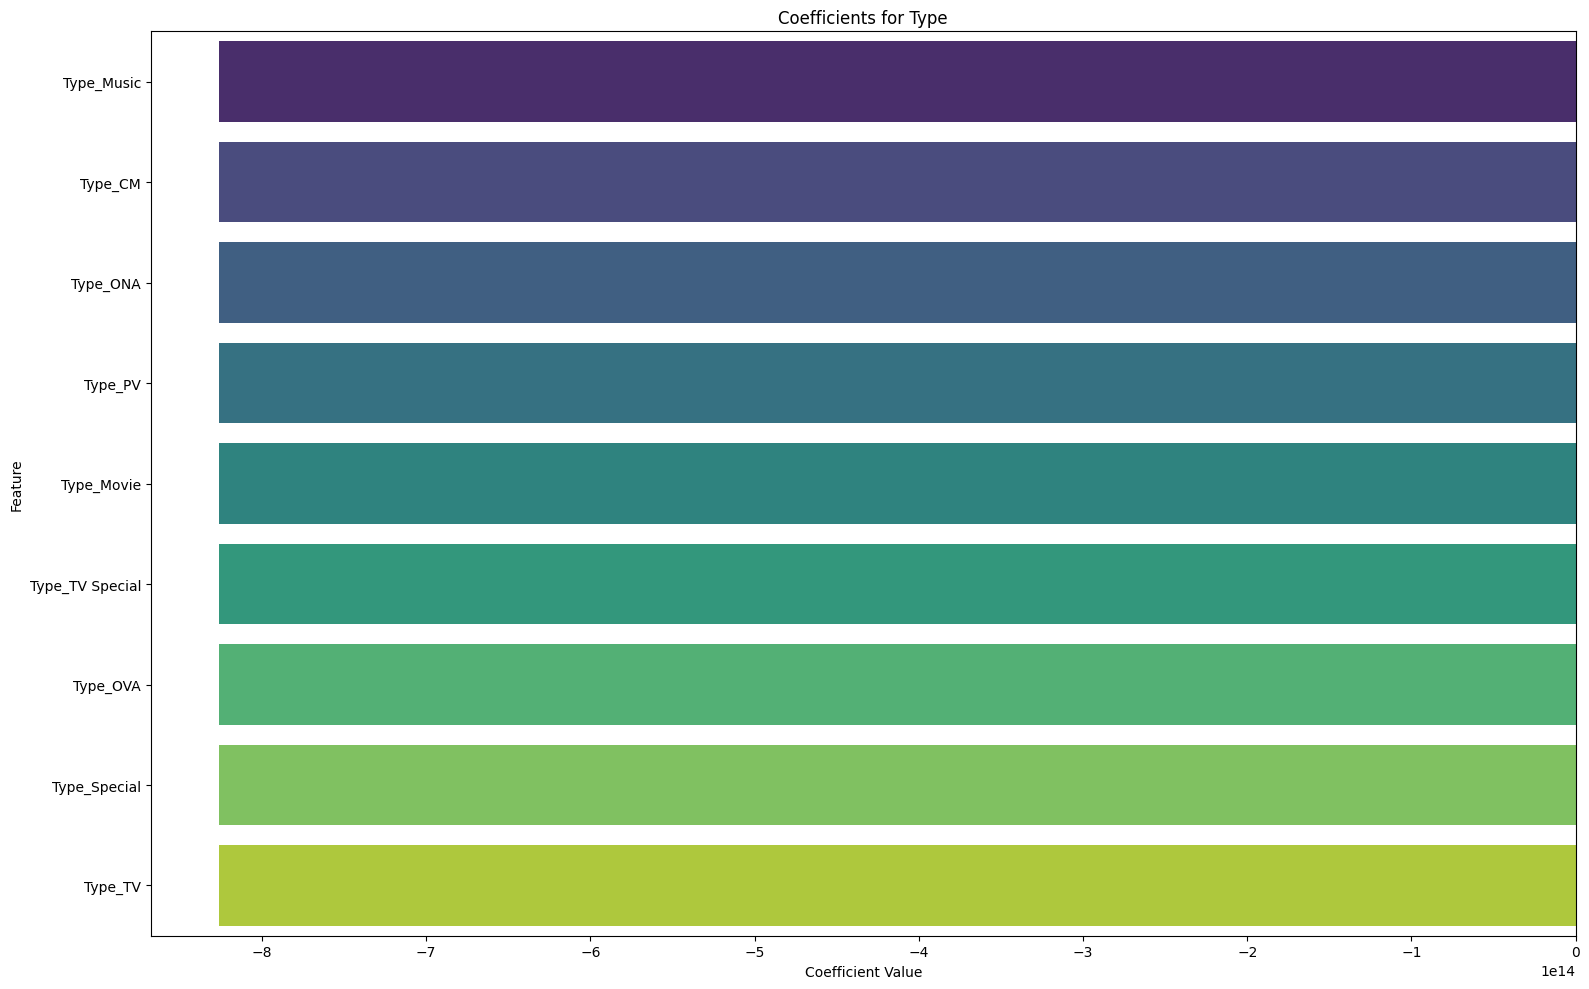

Source - MSE: 16108075.43, R²: 0.27


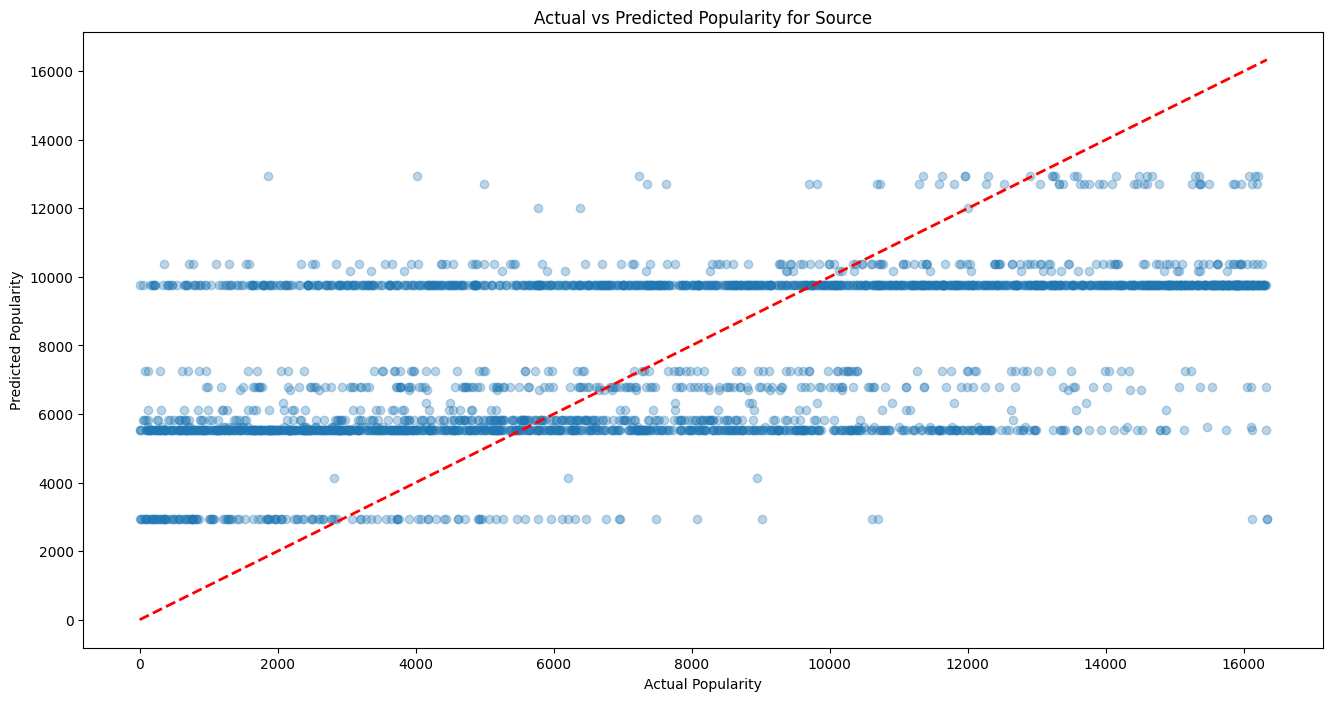

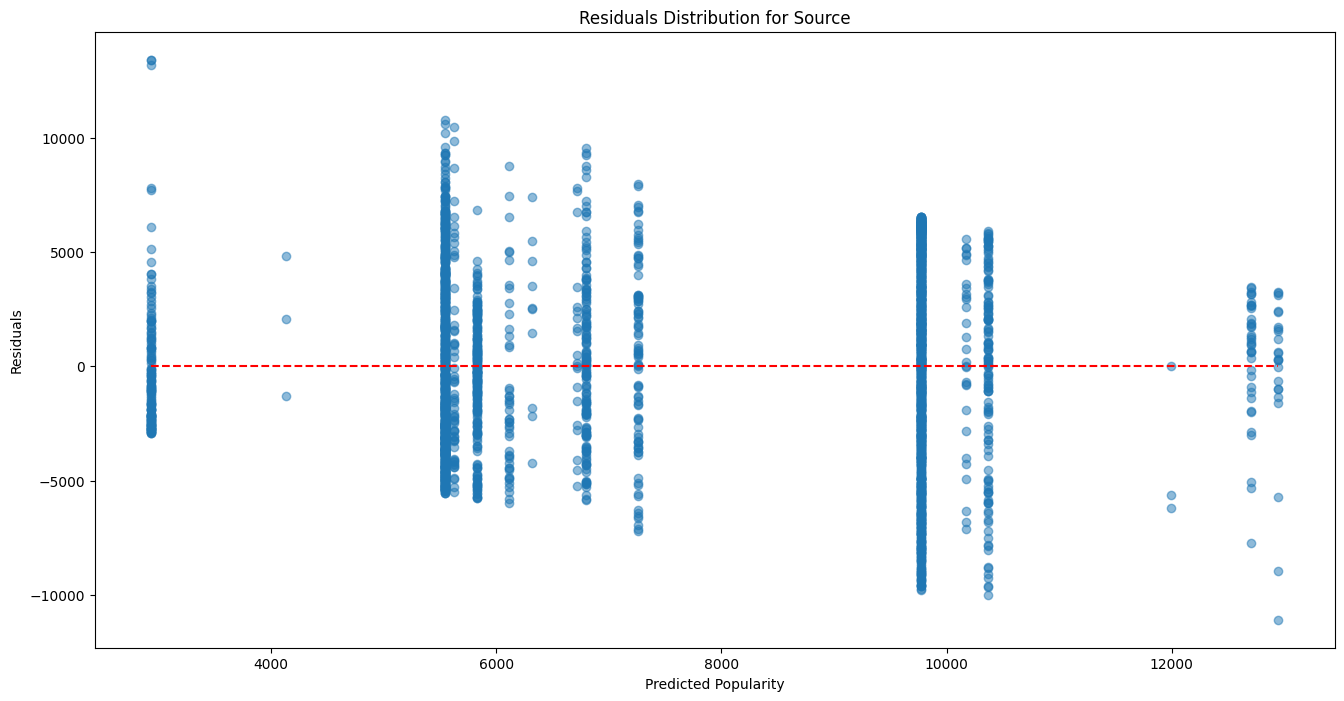

C:\Users\User\AppData\Local\Temp\ipykernel_28512\2727722633.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette="viridis")


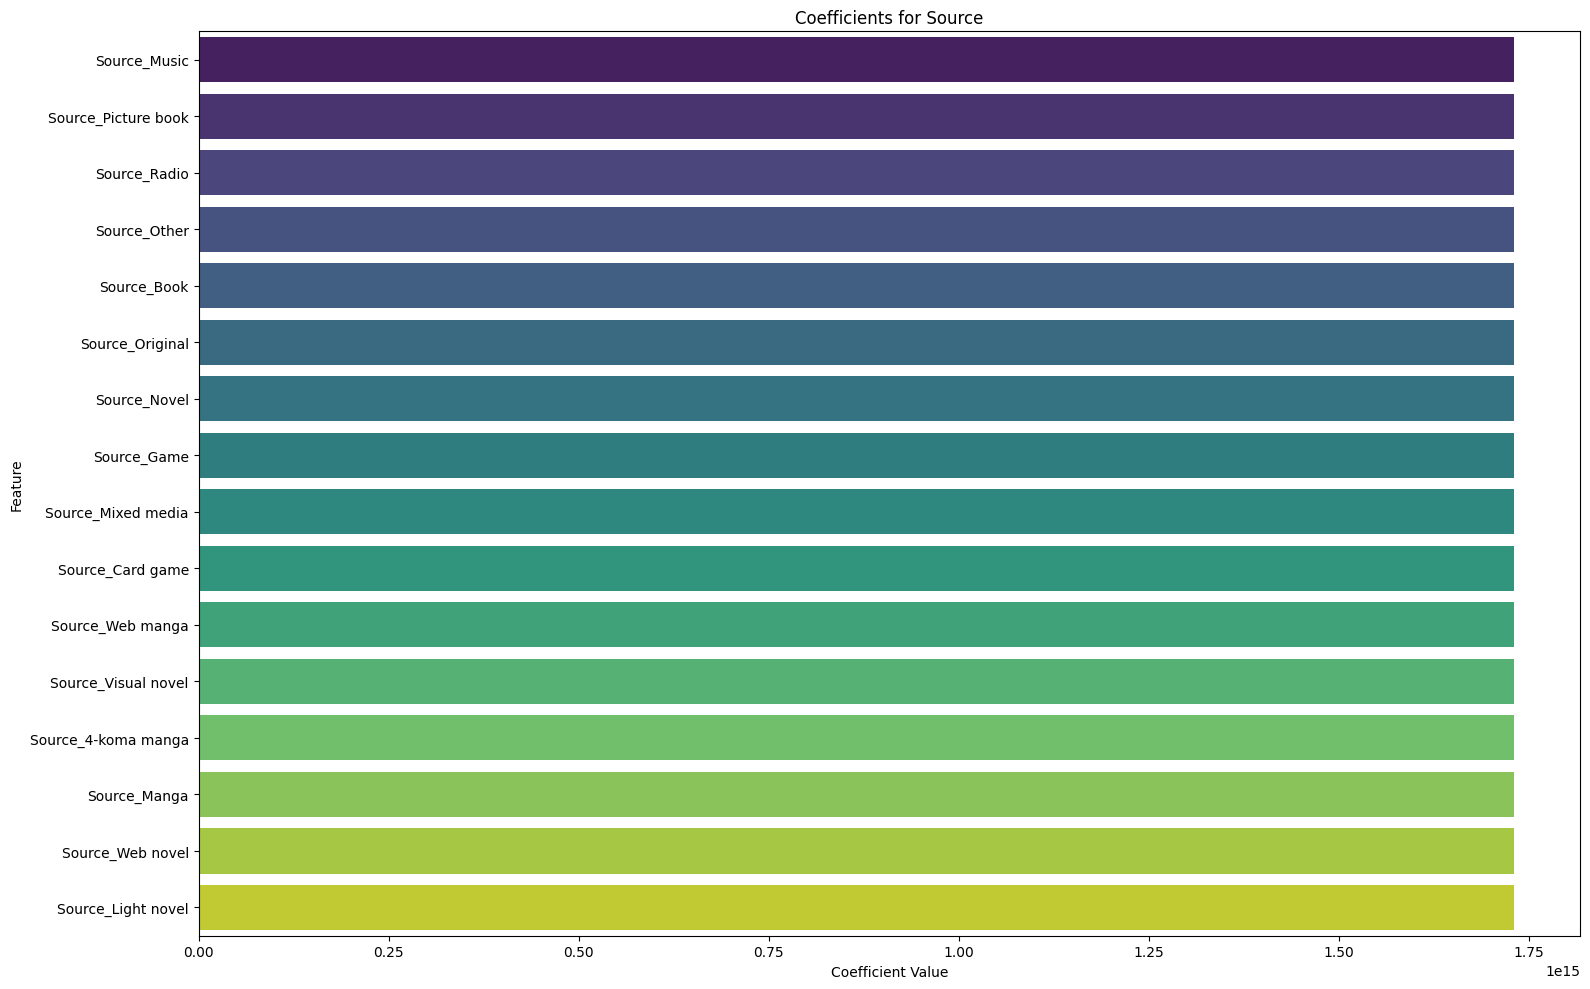

Demographic - MSE: 16458795.59, R²: 0.26


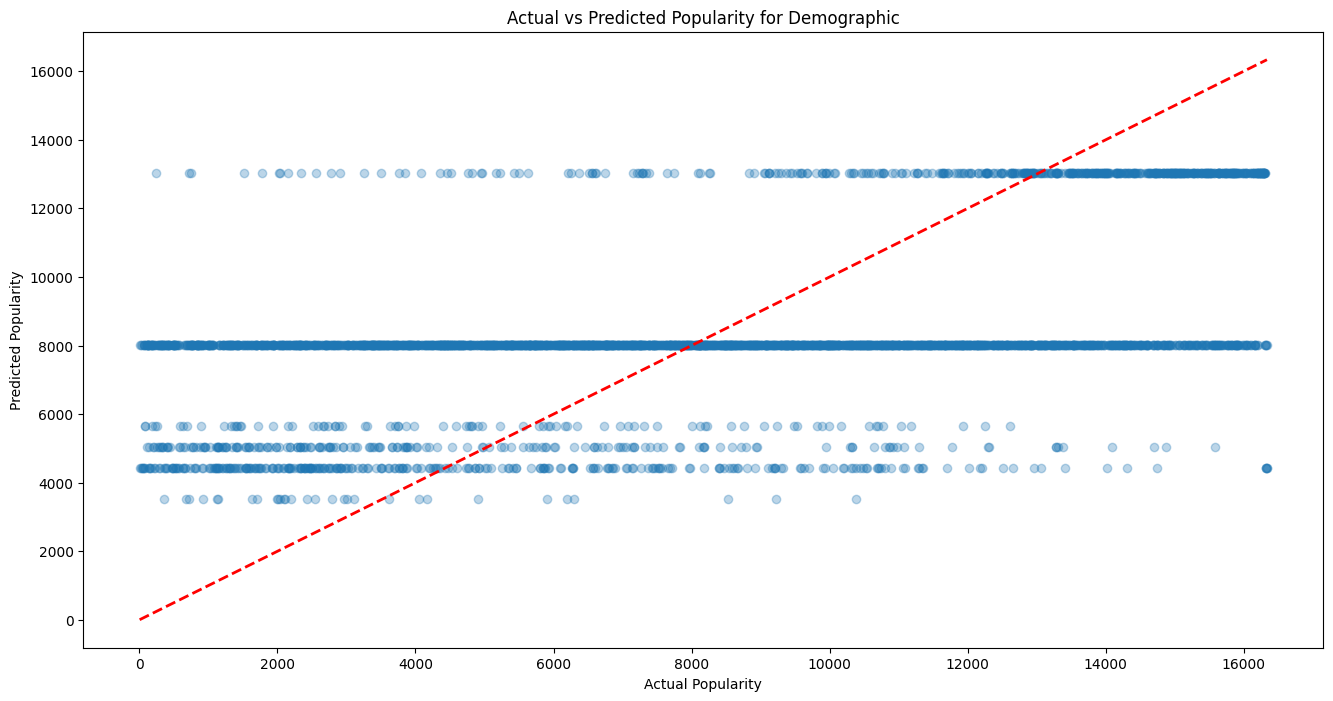

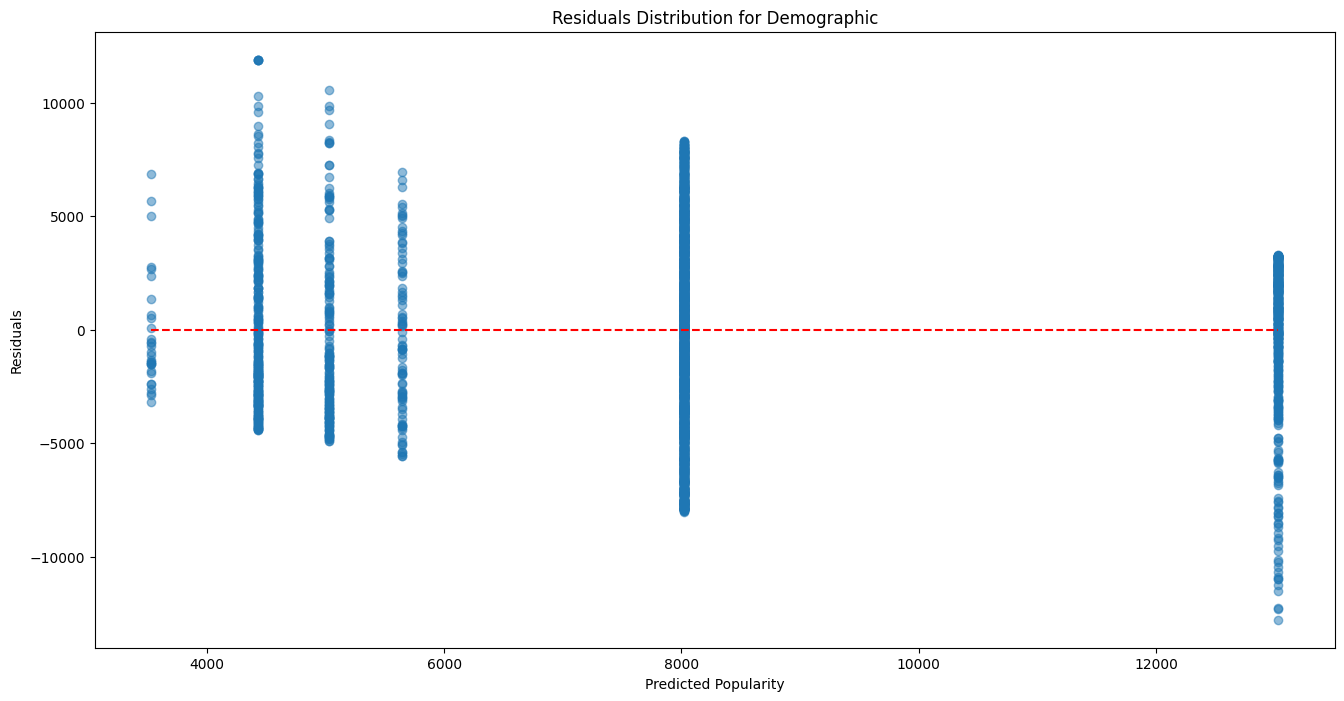

C:\Users\User\AppData\Local\Temp\ipykernel_28512\2727722633.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette="viridis")


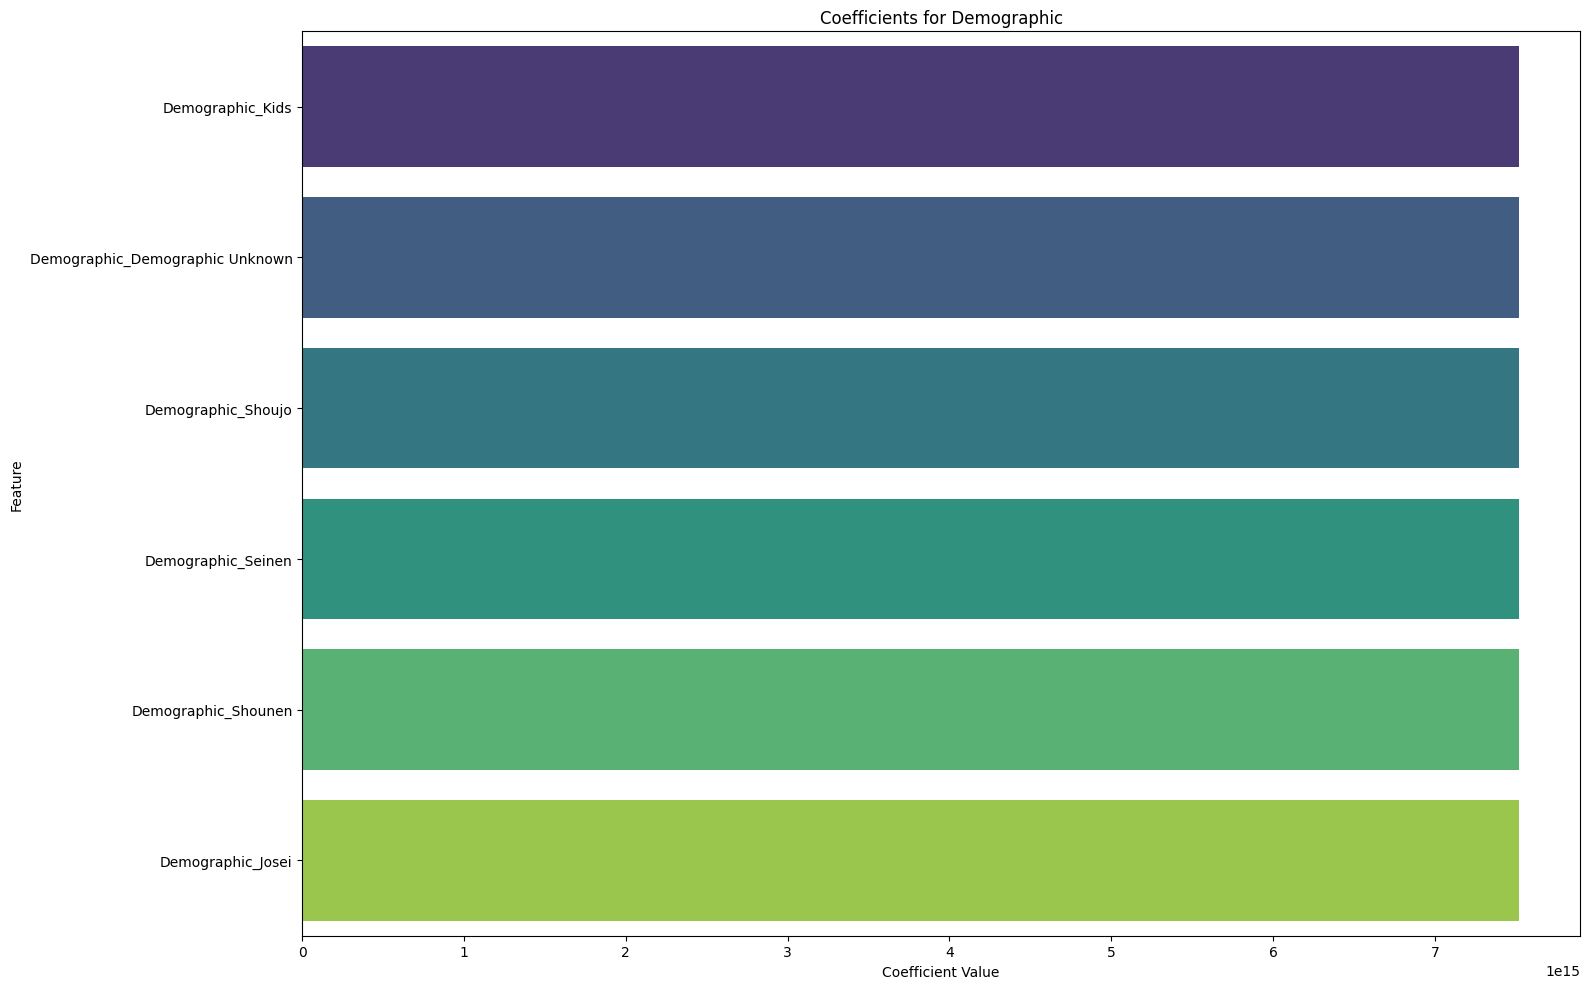

In [56]:
from sklearn.preprocessing import OneHotEncoder
import sklearn

def encode_and_regress(df, column, target='popularity'):
    # Remove NaN values and "[column] Unknown" entries
    valid_data = df[df[column].notna() & (df[column] != "Unknown")]
    
    # Encode the categorical column
    if sklearn.__version__ >= '0.23':
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    else:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    encoded_features = encoder.fit_transform(valid_data[[column]])
    feature_names = encoder.get_feature_names_out([column])
    
    X = pd.DataFrame(encoded_features, columns=feature_names, index=valid_data.index)
    y = valid_data[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{column} - MSE: {mse:.2f}, R²: {r2:.2f}")
    
    # Actual vs Predicted plot
    plt.figure(figsize=(16, 8))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Popularity')
    plt.ylabel('Predicted Popularity')
    plt.title(f'Actual vs Predicted Popularity for {column}')
    plt.show()
    
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(16, 8))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--')
    plt.xlabel('Predicted Popularity')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Distribution for {column}')
    plt.show()
    
    # Coefficient visualization
    coeffs = model.coef_
    coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
    coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
    
    # All coefficients
    plt.figure(figsize=(16, 10))
    sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette="viridis")
    plt.xlabel('Coefficient Value')
    plt.title(f'Coefficients for {column}')
    plt.tight_layout()
    plt.show()

# Assuming main_df is already defined
for column in ['Type', 'Source', 'Demographic']:
    encode_and_regress(main_df, column)